## Step 1:네이버 뉴스에서 기업 뉴스 수집하기
- BeautifulSoup를 사용해 네이버 뉴스 검색 결과에서 뉴스 제목과 URL을 수집합니다.
- 검색어와 페이지 수를 지정할 수 있어 다양한 기업의 뉴스 데이터를 수집할 수 있습니다.

In [132]:
# 필요한 라이브러리 임포트
import requests
from bs4 import BeautifulSoup
import pandas as pd
from urllib.parse import quote

print("[INFO] 필요한 라이브러리 임포트 완료!")

[INFO] 필요한 라이브러리 임포트 완료!


In [133]:
# 뉴스 수집 함수 정의
def get_naver_news(query, pages=1):
    print(f"[INFO] 뉴스 수집 시작: 검색어='{query}', 페이지 수={pages}")
    results = []
    for page in range(1, pages * 10, 10):
        target_url = f"https://search.naver.com/search.naver?where=news&query={query}&start={page}"
        print(f"[DEBUG] 요청 URL: {target_url}")
        encoded_target_url = quote(target_url,  encoding="utf-8")
        print(f"[DEBUG] 요청 URL: {encoded_target_url}")
        url = f"http://api.scrape.do?token=0ad8564c569f4ae0a8ace68e476519e9310be931402&url={encoded_target_url}"
        print(f"[DEBUG] 요청 URL: {url}")

        response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36'})
        if response.status_code != 200:
            print(f"[ERROR] 요청 실패: 상태 코드 {response.status_code}")
            continue
        soup = BeautifulSoup(response.text, "html.parser")
        articles = soup.select("div.Ermefm6A3ilpd9Zvt0OZ")
        print(f"[DEBUG] 페이지 {page//10 + 1} - 수집된 기사 수: {len(articles)}")
        for article in articles:
            title_tag = article.select_one("a.jT1DuARpwIlNAFMacxlu")
            info_group = article.select("div.sds-comps-profile-info a")
            if len(info_group) >= 2:
                url = info_group[1]['href']  # 두 번째 a 태그의 href 속성
            else:
                url = title_tag['href']  # 예비: 만약 두 번째 a 태그 없으면 기존 방식 사용
            title = title_tag.get_text()
            print(f"[DEBUG] 기사 제목: {title} | 원문 URL: {url}")
            content = get_article_content(url)
            results.append({"title": title, "url": url, "content": content})
    print(f"[INFO] 뉴스 수집 완료! 총 수집 건수: {len(results)}")
    return pd.DataFrame(results)

In [134]:
# 본문 내용 크롤링 함수 정의
def get_article_content(article_url):
    try:
        response = requests.get(article_url, headers={'User-Agent': 'Mozilla/5.0'})
        if response.status_code != 200:
            print(f"[ERROR] 기사 본문 요청 실패: {response.status_code} - {article_url}")
            return ""
        soup = BeautifulSoup(response.text, "html.parser")
        content = soup.select_one("#dic_area")
        if content:
            text = content.get_text(strip=True)
            print(f"[DEBUG] 기사 본문 길이: {len(text)}")
            return text
        else:
            print("[WARNING] 본문 선택자에서 내용이 비어 있음")
            return ""
    except Exception as e:
        print(f"[ERROR] 본문 크롤링 중 예외 발생: {e}")
        return ""

In [135]:
# 뉴스 수집 실행
news_df = get_naver_news("sds", pages=2)
print("[INFO] 수집된 뉴스 데이터프레임 미리보기:")
print(news_df.head())

[INFO] 뉴스 수집 시작: 검색어='sds', 페이지 수=2
[DEBUG] 요청 URL: https://search.naver.com/search.naver?where=news&query=sds&start=1
[DEBUG] 요청 URL: https%3A//search.naver.com/search.naver%3Fwhere%3Dnews%26query%3Dsds%26start%3D1
[DEBUG] 요청 URL: http://api.scrape.do?token=0ad8564c569f4ae0a8ace68e476519e9310be931402&url=https%3A//search.naver.com/search.naver%3Fwhere%3Dnews%26query%3Dsds%26start%3D1
[DEBUG] 페이지 1 - 수집된 기사 수: 10
[DEBUG] 기사 제목: [게시판] 삼성SDS '인더스트리 데이' 세미나 | 원문 URL: https://n.news.naver.com/mnews/article/001/0015332990?sid=105
[DEBUG] 기사 본문 길이: 241
[DEBUG] 기사 제목: "제조 특화 솔루션 다 갖췄다"…삼성SDS, 제조업 디지털 혁신 사례 공유 | 원문 URL: https://n.news.naver.com/mnews/article/092/0002370823?sid=105
[DEBUG] 기사 본문 길이: 1487
[DEBUG] 기사 제목: [ZD 브리핑] 美 관세 폭탄 속 韓 기업 1Q 실적 줄줄이 발표…차기 대선 ... | 원문 URL: https://n.news.naver.com/mnews/article/092/0002371316?sid=105
[DEBUG] 기사 본문 길이: 7038
[DEBUG] 기사 제목: 삼성SDS, 1060억 규모 관세청 전산통관시스템 '유니패스' 구축 | 원문 URL: https://n.news.naver.com/mnews/article/031/0000924305?sid=105
[DEBUG] 기사 본문

## Step 2: 감성 분석 준비
- 긍정과 부정 키워드를 정의합니다.
- 뉴스 제목과 본문에서 키워드를 찾아 감성 점수를 계산하는 함수를 준비합니다.

In [136]:
# 긍/부정 키워드 정의
positive_words = ["호재", "성장", "기대", "강세", "최고"]
negative_words = ["리스크", "하락", "위기", "악재", "최저"]
print("[INFO] 감성 분석 키워드 정의 완료!")

[INFO] 감성 분석 키워드 정의 완료!


In [137]:
# 감성 분석 함수 정의
def sentiment_score(text):
    pos = sum(word in text for word in positive_words)
    neg = sum(word in text for word in negative_words)
    score = "Positive" if pos > neg else "Negative" if neg > pos else "Neutral"
    print(f"[DEBUG] 텍스트 길이: {len(text)} | 긍정: {pos}, 부정: {neg}, 결과: {score}")
    return score

## Step 3: 뉴스 감성 분석 적용
- 뉴스 제목 + 본문을 활용하여 감성 점수를 계산합니다.

In [138]:
print("[INFO] 감성 분석 적용 시작!")
news_df['sentiment'] = news_df.apply(lambda row: sentiment_score(row['title'] + ' ' + row['content']), axis=1)
print("[INFO] 감성 분석 적용 완료!")
print(news_df.head())

[INFO] 감성 분석 적용 시작!
[DEBUG] 텍스트 길이: 268 | 긍정: 0, 부정: 0, 결과: Neutral
[DEBUG] 텍스트 길이: 1529 | 긍정: 0, 부정: 0, 결과: Neutral
[DEBUG] 텍스트 길이: 7085 | 긍정: 2, 부정: 1, 결과: Positive
[DEBUG] 텍스트 길이: 1305 | 긍정: 1, 부정: 0, 결과: Positive
[DEBUG] 텍스트 길이: 20 | 긍정: 0, 부정: 0, 결과: Neutral
[DEBUG] 텍스트 길이: 35 | 긍정: 0, 부정: 0, 결과: Neutral
[DEBUG] 텍스트 길이: 32 | 긍정: 0, 부정: 0, 결과: Neutral
[DEBUG] 텍스트 길이: 3340 | 긍정: 1, 부정: 0, 결과: Positive
[DEBUG] 텍스트 길이: 1140 | 긍정: 0, 부정: 0, 결과: Neutral
[DEBUG] 텍스트 길이: 2688 | 긍정: 0, 부정: 1, 결과: Negative
[DEBUG] 텍스트 길이: 37 | 긍정: 0, 부정: 0, 결과: Neutral
[DEBUG] 텍스트 길이: 324 | 긍정: 1, 부정: 0, 결과: Positive
[DEBUG] 텍스트 길이: 34 | 긍정: 0, 부정: 0, 결과: Neutral
[DEBUG] 텍스트 길이: 36 | 긍정: 0, 부정: 0, 결과: Neutral
[DEBUG] 텍스트 길이: 523 | 긍정: 0, 부정: 0, 결과: Neutral
[DEBUG] 텍스트 길이: 3402 | 긍정: 0, 부정: 1, 결과: Negative
[DEBUG] 텍스트 길이: 29 | 긍정: 0, 부정: 0, 결과: Neutral
[DEBUG] 텍스트 길이: 23 | 긍정: 0, 부정: 0, 결과: Neutral
[DEBUG] 텍스트 길이: 42 | 긍정: 0, 부정: 0, 결과: Neutral
[DEBUG] 텍스트 길이: 997 | 긍정: 0, 부정: 0, 결과: Neutral
[INFO] 감성 분석 적용 

## Step 4: 데이터 시각화
- 워드클라우드를 통해 자주 등장하는 키워드를 시각화합니다.
- 감성 분포를 파이 차트로 나타내어 긍/부정 비율을 시각적으로 확인합니다.

In [139]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

print("[INFO] 데이터 시각화 시작!")

# Colab 환경에서 한글 폰트 설치
!apt-get update -qq
!apt-get install -y fonts-nanum
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

[INFO] 데이터 시각화 시작!
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45684 (\N{HANGUL SYLLABLE NYU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

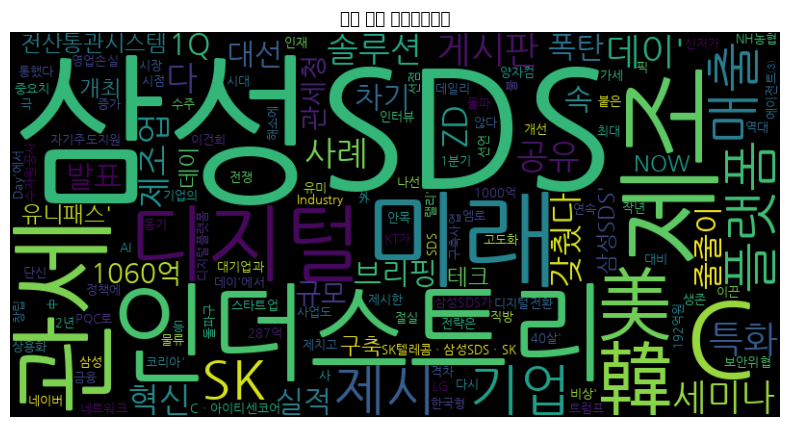

[INFO] 워드클라우드 시각화 완료!


In [140]:
# 워드클라우드 생성
text = ' '.join(news_df['title'])
wordcloud = WordCloud(font_path=font_path, width=800, height=400).generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("뉴스 제목 워드클라우드")
plt.show()

print("[INFO] 워드클라우드 시각화 완료!")

[INFO] 감성 분포:
sentiment
Neutral     14
Positive     4
Negative     2
Name: count, dtype: int64


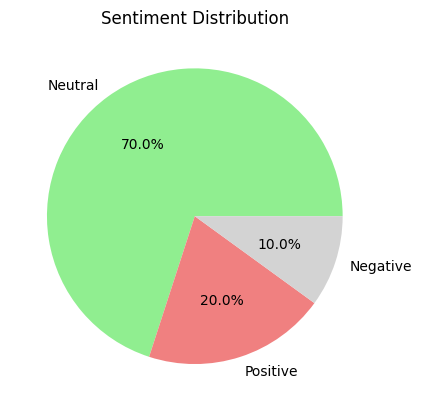

In [141]:
# 감성 분포 시각화
sentiment_counts = news_df['sentiment'].value_counts()
print("[INFO] 감성 분포:")
print(sentiment_counts)
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightcoral', 'lightgrey'])
plt.title('Sentiment Distribution')
plt.ylabel('')
plt.show()

## Step 5: 분석 결과 DuckDB에 저장
- DuckDB를 사용하여 로컬 또는 클라우드 환경에서도 SQL 기반으로 데이터를 다룰 수 있습니다.
- 분석 결과를 DuckDB 데이터베이스 파일로 저장합니다.
- 저장된 데이터는 추후 SQL 쿼리로 분석하거나 외부 시스템과 연동할 수 있습니다.

In [142]:
print("[INFO] DuckDB에 저장 시작!")

# DuckDB 설치 및 임포트
!pip install duckdb
import duckdb

# DuckDB에 데이터 저장
con = duckdb.connect(database='news_sentiment.duckdb', read_only=False)
print("[INFO] DuckDB 연결 성공!")
con.execute("CREATE TABLE IF NOT EXISTS news_sentiment AS SELECT * FROM news_df")
print("[INFO] 데이터 저장 완료!")
con.close()
print("[INFO] DuckDB 연결 종료!")

[INFO] DuckDB에 저장 시작!
[INFO] DuckDB 연결 성공!
[INFO] 데이터 저장 완료!
[INFO] DuckDB 연결 종료!


## Step 6: Streamlit 웹 서비스 실행
-  Streamlit을 사용하여 분석된 데이터를 웹 브라우저에서 시각화합니다.
- DuckDB에 저장된 데이터를 불러와 데이터 테이블, 감성 분포 차트, 뉴스 원문 링크를 제공합니다.
- ngrok을 사용하여 외부에서 접근 가능한 URL을 생성합니다.


## Step 6: Streamlit 웹 서비스 실행
- app.py 파일 생성
- 서비스 코드 작성

In [143]:
print("[INFO] Streamlit 웹 서비스 준비 시작!")

# 필요한 라이브러리 설치
!pip install streamlit pyngrok --quiet

[INFO] Streamlit 웹 서비스 준비 시작!


In [144]:
# ngrok으로 공개 URL 생성 (Authtoken 필요)
from pyngrok import ngrok

# 여기에 발급받은 ngrok authtoken 입력하세요!
NGROK_AUTH_TOKEN = "2w1lMu0vDS1pgY2wDQ0d4mJ8IyP_2Jim9cP1bo2r65A59DGmo"

In [147]:
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

print("[INFO] ngrok 터널 생성 중...")
public_url = ngrok.connect(addr="8501", proto="http")
print(f"[INFO] Streamlit 앱 Public URL: {public_url}")

# Streamlit 앱 실행
!streamlit run app.py --server.port 8501 --server.enableCORS false

print("[INFO] Streamlit 웹 서비스가 실행되었습니다. 위의 Public URL을 클릭하여 접속하세요!")

[INFO] ngrok 터널 생성 중...
[INFO] Streamlit 앱 Public URL: NgrokTunnel: "https://3089-34-138-247-166.ngrok-free.app" -> "http://localhost:8501"
2025-04-21 07:20:46.912 
As a result, 'server.enableCORS' is being overridden to 'true'.

More information:
In order to protect against CSRF attacks, we send a cookie with each request.
To do so, we must specify allowable origins, which places a restriction on
cross-origin resource sharing.

If cross origin resource sharing is required, please disable server.enableXsrfProtection.
            


2025-04-21 07:20:47.038 Port 8501 is already in use
[INFO] Streamlit 웹 서비스가 실행되었습니다. 위의 Public URL을 클릭하여 접속하세요!
